# TP13
Criar um Oráculo que encontre o estado |001> numa lista de 8 elementos.

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *

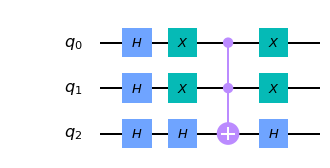

In [2]:
qc = QuantumCircuit(3)

#inicialização
qc.h([ 0, 1, 2])

#oráculo que altera a fase
qc.x([ 0, 1 ])

qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)

qc.x([ 0, 1 ])

qc.draw(output='mpl')

In [3]:
backend_state = Aer.get_backend('statevector_simulator')
result = execute(qc, backend_state).result()
psi2  = result.get_statevector(qc)

In [4]:
psi2.real

array([ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
        0.35355339,  0.35355339,  0.35355339])

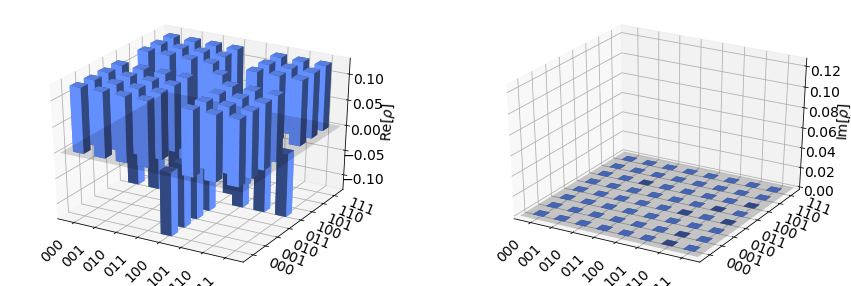

In [5]:
plot_state_city(psi2)

In [6]:
#nº de bits
n = 3
N = 2 ** n

In [7]:
def ccZ(circuit, c1, c2, t):
    circuit.h(t)
    circuit.ccx(c1, c2, t)
    circuit.h(t)
    #circuit.barrier()

def select_w(circuit, qr):
    circuit.x([ qr[0], qr[1] ])
    #circuit.barrier()

def phase_oracle(circuit, qr):
    select_w(circuit, qr)
    ccZ(circuit, qr[0], qr[1], qr[2])
    select_w(circuit, qr)
    #circuit.barrier()


### Oracle $U_w$

In [8]:
def diffuser(circuit, x):
    circuit.h(x)
    circuit.x(x)
    ccZ(circuit, x[0], x[1], x[2])
    circuit.x(x)
    circuit.h(x)

In [9]:
import math as m
times = round((m.pi/4) * m.sqrt(N))
times

2

In [10]:
backend = Aer.get_backend("qasm_simulator")

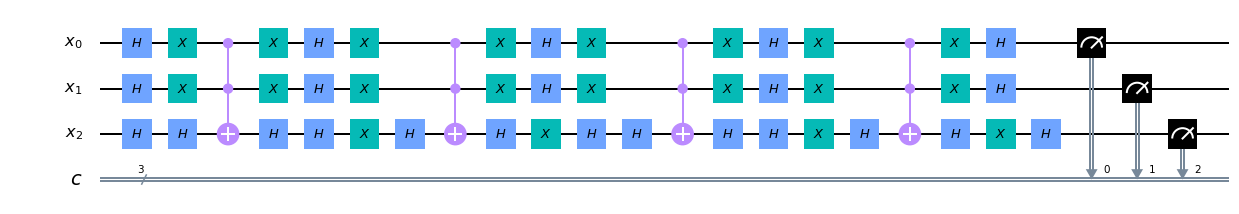

In [11]:
cr = ClassicalRegister(n,'c')
qr = QuantumRegister(n, 'x')

qc_Grover = QuantumCircuit(qr,cr)

# 1.init
qc_Grover.h(qr)

#qc_Grover.barrier()

# 2.oracle and diffuser 

for t in range(times):
    # a)
    phase_oracle(qc_Grover, qr)
    # b)
    diffuser(qc_Grover, qr)

# 3.     
qc_Grover.measure(qr, cr)
qc_Grover.draw(output='mpl')

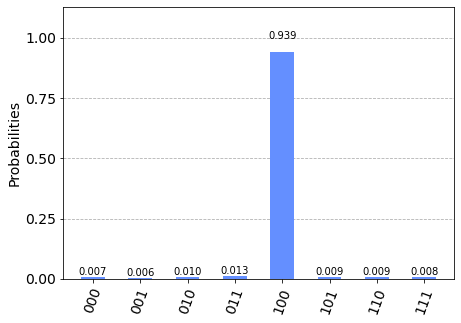

In [12]:
shots = 1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

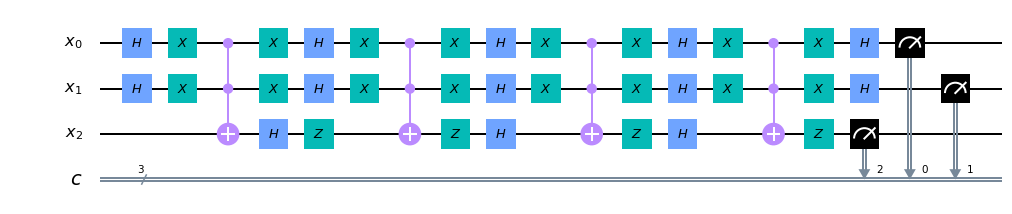

In [13]:
cr = ClassicalRegister(n,'c')
qr = QuantumRegister(n, 'x')

qc_short = QuantumCircuit(qr,cr)

qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])
#qc_short.h(qr[2])
#qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if True:
    qc_short.h(qr[2])
    qc_short.z(qr[2])
else:
    qc_short.x(qr[2])
    qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if True:
    qc_short.z(qr[2])
    qc_short.h(qr[2])
else:
    qc_short.h(qr[2])
    qc_Short.x(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if True:
    qc_short.z(qr[2])
    qc_short.h(qr[2])
else:
    qc_short.h(qr[2])
    qc_short.x(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.z(qr[2])

#qc_short.barrier()

qc_short.measure(qr, cr)

qc_short.draw('mpl')

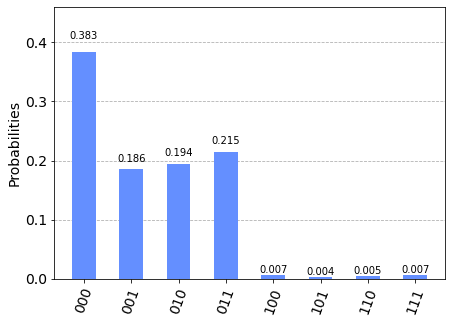

In [14]:
shots = 1024
result = execute(qc_short, backend, shots=shots).result()
counts_sim = result.get_counts(qc_short)
plot_histogram(counts_sim)